In [51]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from shapely.geometry import Polygon, Point, LinearRing, box
import matplotlib.cm as cmx
# import seaborn as sns; sns.set()
import math
%matplotlib notebook

In [ ]:
poly = box(3750901.5068,-19268905.6133, 3770901.5068, -19208905.6133)

def city_distance(x, y):
    if ((x >= 3750901.5068) & (x <= 3770901.5068) & (y >= -19268905.6133) & (y <= -19208905.6133)):
        point = Point(x, y)
        pol_ext = LinearRing(poly.exterior.coords)
        d = pol_ext.project(point)
        p = pol_ext.interpolate(d)
        closest_point_coords = list(p.coords)[0]
        
        return -point.distance(Point(closest_point_coords))
    else:
        point = Point(x, y)
        pol_ext = LinearRing(poly.exterior.coords)
        d = pol_ext.project(point)
        p = pol_ext.interpolate(d)
        closest_point_coords = list(p.coords)[0]
        
        return point.distance(Point(closest_point_coords))

In [ ]:
df_train = pd.read_csv("../../data/data_train.csv")
df_test = pd.read_csv("../../data/data_test.csv")
df_train['time_entry'] = pd.to_timedelta(df_train['time_entry'])
df_train['time_exit'] = pd.to_timedelta(df_train['time_exit'])
df_test['time_entry'] = pd.to_timedelta(df_test['time_entry'])
df_test['time_exit'] = pd.to_timedelta(df_test['time_exit'])
df_train['duration'] = df_train['time_exit'] - df_train['time_entry']
df_train['duration'] = df_train['duration'].dt.total_seconds()
df_test['duration'] = df_test['time_exit'] - df_test['time_entry']
df_test['duration'] = df_test['duration'].dt.total_seconds()
df_train['distance'] = df_train.apply(lambda row: Point(row['x_entry'],row['y_entry']).
                                      distance(Point(row['x_exit'],row['y_exit'])), axis=1)
df_train['velocity'] = df_train.apply(lambda row: (row['distance']/row['duration'])
                                      if row['duration']!= 0.0 else 0.0, axis=1)

In [ ]:
df_test['city_distance'] = df_test.apply(lambda row: city_distance(row['x_entry'], row['y_entry']), axis = 1)
df_train['city_distance'] = df_train.apply(lambda row: city_distance(row['x_entry'], row['y_entry']), axis = 1)
print("*****City Distance done*****")
df_train['ratio'] = df_train.apply(lambda row: (row['city_distance']/row['duration'])
                                      if row['duration']!= 0.0 else 0.0, axis=1)
df_test['ratio'] = df_test.apply(lambda row: (row['city_distance']/row['duration'])
                                      if row['duration']!= 0.0 else 0.0, axis=1)
print("*****Ratio done*****")
df_train['label']= -1
df_train['label'] = df_train.apply(lambda row: 1 
                                 if ((row['x_exit'] >= 3750901.5068) & (row['x_exit'] <= 3770901.5068) & 
                                     (row['y_exit'] >= -19268905.6133) & (row['y_exit'] <= -19208905.6133)) 
                                 else 0, axis=1)
df_test['label']= -1
df_test['label'] = df_test.apply(lambda row: 1 
                                 if ((row['duration'] == 0.0)&(math.isnan(row['x_exit'])) & (math.isnan(row['y_exit'])) &
                                      (row['x_entry'] >= 3750901.5068) & (row['x_entry'] <= 3770901.5068) & 
                                      (row['y_entry'] >= -19268905.6133) & (row['y_entry'] <= -19208905.6133)) 
                                 else row['label'], axis=1)
df_test['label'] = df_test.apply(lambda row: 0 
                                 if ((row['duration'] == 0.0)&(math.isnan(row['x_exit'])) & (math.isnan(row['y_exit'])) &
                                     (row['label'] == -1))
                                 else row['label'], axis=1)
print("*****Label done*****")

In [ ]:
df_train.to_pickle('df_train')
df_test.to_pickle('df_test')

In [53]:
test = df_test[(df_test['duration'] != 0.0) & (df_test.x_exit.isnull()) & (df_test.y_exit.isnull())]
start_time = '0 days 15:00:00'
end_time = '0 days 16:00:00'
dd = df_train[(df_train['time_exit'] >= start_time) & (df_train['time_exit'] <= end_time)]
dd[(dd['duration'] == 0.0) & (dd['x_exit'] >= 3750901.5068) & 
         (dd['x_exit'] <= 3770901.5068) & (dd['y_exit'] >= -19268905.6133) & 
         (dd['y_exit'] <= -19208905.6133)].label.value_counts()
dd[(dd['duration'] == 0.0) & ((dd['x_exit'] < 3750901.5068) | 
         (dd['x_exit'] > 3770901.5068)) & ((dd['y_exit'] < -19268905.6133) | 
         (dd['y_exit'] > -19208905.6133))].label.value_counts()
dd_1 = dd[(dd['duration'] != 0.0) & (dd['x_exit'] >= 3750901.5068) & 
         (dd['x_exit'] <= 3770901.5068) & (dd['y_exit'] >= -19268905.6133) & 
         (dd['y_exit'] <= -19208905.6133)]
train = dd[dd['duration'] != 0.0]
all_test = df_test.loc[df_test['hash'].isin(test.hash.values)]
all_train = df_train.loc[df_train['hash'].isin(train.hash.values)]

In [ ]:
train.to_pickle('train')
test.to_pickle('test')

In [5]:
df = df_train.groupby('hash')
df_list = list(df)
df_2 = df_test.groupby('hash')
df_2_list = list(df_2)
# df.to_pickle('df_list')
# df_2.to_pickle('df_2_list')

In [4]:
df_train = pd.read_pickle('df_train')
df_test = pd.read_pickle('df_test')
train = pd.read_pickle('train')
test = pd.read_pickle('test')
# df_list = list(pd.read_pickle('df'))
# df_2_list = list(pd.read_pickle('df_2'))

In [ ]:
tt = df_train[(df_train['x_exit'] >= 3750901.5068) & (df_train['x_exit'] <= 3770901.5068) & 
              (df_train['y_exit'] >= -19268905.6133) & (df_train['y_exit'] <= -19208905.6133)]
tt2 = df_test[(df_test['x_exit'] >= 3750901.5068) & (df_test['x_exit'] <= 3770901.5068) & 
              (df_test['y_exit'] >= -19268905.6133) & (df_test['y_exit'] <= -19208905.6133)]

In [43]:
print(len(all_test.groupby(['hash']).filter(lambda x: len(x)==1).groupby('hash')))
print(len(all_test.groupby(['hash']).filter(lambda x: len(x)==2).groupby('hash')))
print(len(all_test.groupby(['hash']).filter(lambda x: len(x)==3).groupby('hash')))
print(len(all_test.groupby(['hash']).filter(lambda x: len(x)==4).groupby('hash')))
print(len(all_test.groupby(['hash']).filter(lambda x: len(x)==5).groupby('hash')))

184
754
2902
2654
2131


In [44]:
print(len(all_test.groupby(['hash']).filter(lambda x: len(x)==6).groupby('hash')))
print(len(all_test.groupby(['hash']).filter(lambda x: len(x)==7).groupby('hash')))
print(len(all_test.groupby(['hash']).filter(lambda x: len(x)==8).groupby('hash')))
print(len(all_test.groupby(['hash']).filter(lambda x: len(x)==9).groupby('hash')))
print(len(all_test.groupby(['hash']).filter(lambda x: len(x)==10).groupby('hash')))
print(len(all_test.groupby(['hash']).filter(lambda x: len(x)==11).groupby('hash')))

1803
1465
1111
885
675
548


<IPython.core.display.Javascript object>


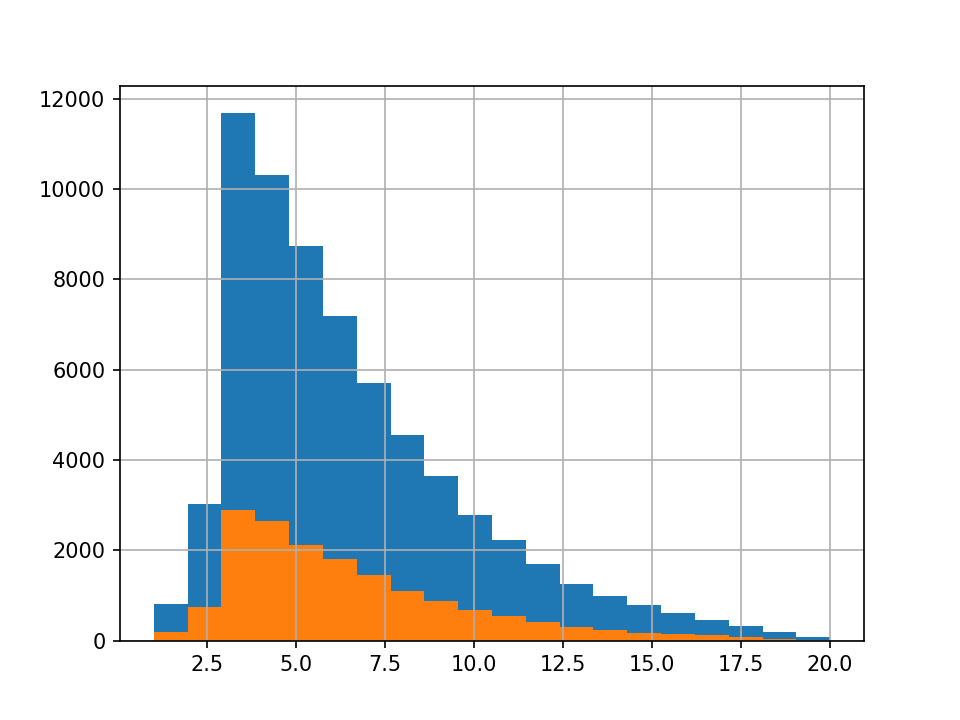

In [60]:
plt.clf()
(all_train.groupby(['hash']).agg('count')['trajectory_id'].hist(bins = 20))
(all_test.groupby(['hash']).agg('count')['trajectory_id'].hist(bins = 20))

In [55]:
all_train.groupby(['hash']).size().describe()

count    67065.000000
mean         6.305539
std          3.540651
min          1.000000
25%          4.000000
50%          5.000000
75%          8.000000
max         20.000000
dtype: float64

# Plottings

In [ ]:
def plot_trajectory(df_sample):
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                             (- 19268905.6133 + 19208905.6133),
                             linewidth=1,edgecolor='g',fill = False,hatch = '\\\\\\', label = 'city center')
    city = plt.gca().add_patch(rect)
    for index, row in df_sample.iterrows():
#         lines = plt.plot(df_sample.x_exit,df_sample.y_exit, label='Lines', color = 'g')
        arrows = plt.arrow(row['x_entry'], row['y_entry'], row['x_exit'] - row['x_entry'], row['y_exit'] - row['y_entry'],
                  label ='Trajectory', color = 'b')
    entries = plt.scatter(df_sample.x_entry,df_sample.y_entry, label='Entry point', color = 'b')
    exits = plt.scatter(df_sample.x_exit,df_sample.y_exit, label='Exit point', color = 'r')
#     lines = plt.plot(df_sample.x_exit,df_sample.y_exit, label='Lines', color = 'g')
    plt.legend(handles=[city, arrows])
    plt.grid(True)
    plt.show()

In [29]:
def plot_fig(train):
    fig, ax = plt.subplots(2,1)
#     rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
#                                  (- 19268905.6133 + 19208905.6133),
#                                  linewidth=1,edgecolor='g',fill = False,hatch = '\\\\\\', label = 'city center')
    ax[0].scatter(train.x_entry,train.y_entry, label='Entry point', color = 'b', s = 0.05)
    ax[0].axis('off')
    ax[1].scatter(train.x_exit,train.y_exit, label='Exit point', color = 'r', s = 0.05)
    ax[1].axis('off')
#     ax[0].gca().add_patch(rect)
#     ax[1].gca().add_patch(rect)

In [33]:
def plot_fig_entry(train):
#     cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                                 (- 19268905.6133 + 19208905.6133),
                                 linewidth=1,edgecolor='g',fill = False, label = 'city center')
    entries = plt.scatter(train.x_entry,train.y_entry, label='Entry point', c = 'b', s=0.05)
#     exits = plt.scatter(train.x_exit,train.y_exit, label='Exit point', c = train.velocity, s = 0.05, cmap=cmap)
#     for index, row in train.iterrows():
#         arrows = plt.arrow(row['x_entry'], row['y_entry'], row['x_exit'] - row['x_entry'], row['y_exit'] - row['y_entry'],
#                   label ='Not in City', color = 'b', linewidth = 0.01)
    city = plt.gca().add_patch(rect)
    plt.legend(handles = [city])
#     plt.colorbar(entries)
    plt.grid(True)
#     plt.savefig('foo.png', dpi=1200)
    plt.show()

In [ ]:
def plot_fig_exits(train):
    cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                                 (- 19268905.6133 + 19208905.6133),
                                 linewidth=1,edgecolor='g',fill = False, label = 'city center')
#     entries = plt.scatter(train.x_entry,train.y_entry, label='Entry point', c = train.velocity, s=0.05, cmap=cmap)
    exits = plt.scatter(train.x_exit,train.y_exit, label='Exit point', c = 'r', s = 0.05)
#     for index, row in train.iterrows():
#         arrows = plt.arrow(row['x_entry'], row['y_entry'], row['x_exit'] - row['x_entry'], row['y_exit'] - row['y_entry'],
#                   label ='Not in City', color = 'b', linewidth = 0.01)
    city = plt.gca().add_patch(rect)
    plt.legend(handles = [city])
    plt.colorbar(entries)
    plt.grid(True)
#     plt.savefig('foo.png', dpi=1200)
    plt.show()

In [ ]:
def plot_test_fig(sample):
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                                 (- 19268905.6133 + 19208905.6133),
                                 linewidth=1,edgecolor='g',fill = False,hatch = '\\\\\\', label = 'city center')
    entries = plt.scatter(sample.x_entry,sample.y_entry, label='Entry point', color = 'b', s = 0.002)
    city = plt.gca().add_patch(rect)
    plt.legend(handles = [city,entries])
    plt.title("All test starting point in map")
    plt.grid(True)
    plt.savefig('foo1.png', dpi=1200)
    plt.show()

In [ ]:
plot_trajectory(df_list[100][1])

In [ ]:
def plot_point(row):
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                             (- 19268905.6133 + 19208905.6133),
                             linewidth=1,edgecolor='g',fill = False,hatch = '\\\\\\', label = 'city center')
    city = plt.gca().add_patch(rect)
    entries = plt.scatter(row['x_entry'],row['y_entry'], label='Entry point', color = 'b')
    plt.legend(handles=[city, entries])
    plt.grid(True)
    plt.show()

In [ ]:
def plot_row(row):
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                             (- 19268905.6133 + 19208905.6133),
                             linewidth=1,edgecolor='g',fill = False, label = 'city center')
    city = plt.gca().add_patch(rect)
#     arrows = plt.plot([row['x_entry'], row['x_exit']], [row['y_entry'], row['y_exit']], 
#                       label ='Trajectory', color = 'b')
    entries = plt.scatter(row['x_entry'],row['y_entry'], label='Entry point', color = 'b')
    exits = plt.scatter(row['x_exit'],row['y_exit'], label='Exit point', color = 'r')
    
    point = Point(row['x_entry'], row['y_entry'])
    pol_ext = LinearRing(poly.exterior.coords)
    d = pol_ext.project(point)
    p = pol_ext.interpolate(d)
    closest_point_coords = list(p.coords)[0]
    print(p.distance(point), poly.boundary.distance(point), p)
    
    cityClose = plt.scatter(closest_point_coords[0],closest_point_coords[1], label='closest boundary', color = 'y')
#     plt.legend(handles=[city,entries, exits, cityClose])
    plt.grid(True)
    plt.show()

# Test Explore

In [ ]:
df_test[(df_test.x_exit.isnull()) & (df_test.y_exit.isnull())].duration.describe()

In [ ]:
df_test[(df_test['duration'] > 0) & (df_test['duration'] < 5000) & (df_test.x_exit.isnull()) & (df_test.y_exit.isnull())].duration.describe()

In [ ]:
plt.scatter(df_train[df_train['velocity'] != 0.0].distance, df_train[df_train['velocity'] != 0.0].duration)

In [ ]:
df_test[df_test.x_exit.isnull()]['label'].value_counts()

In [ ]:
df_test['label'] = df_test['label'].replace(-1,0)

In [ ]:
df_test[df_test.x_exit.isnull()][['trajectory_id', 'label']].to_csv('output.csv', index=False)

# Train explore

In [ ]:
df_train[(df_train['duration'] == 0.0) & ((df_train['x_entry'] != df_train['x_exit']) |
         (df_train['y_entry'] != df_train['y_exit']))]

In [ ]:
df_train[(df_train['duration'] == 0.0) & (df_train['x_entry'] == df_train['x_exit']) &
         (df_train['y_entry'] == df_train['y_exit'])].shape[0]

In [ ]:
df_train.label.value_counts()

In [ ]:
df_train[(df_train['duration'] == 0.0) & (df_train['x_exit'] >= 3750901.5068) & 
         (df_train['x_exit'] <= 3770901.5068) & (df_train['y_exit'] >= -19268905.6133) & 
         (df_train['y_exit'] <= -19208905.6133)]

# Explorations

In [ ]:
ax = sns.scatterplot(x="duration", y="city_distance", hue = 'label', data=dd[(dd['duration']!=0)&(dd['label'] == 1)])

In [ ]:
plt.clf()
plot_trajectory(dd_1)

In [ ]:
plt.clf()
plot_fig(train[train['label'] == 0])

In [ ]:
plt.clf()
plot_test_fig(df_test[(df_test['duration'] > 0) & (df_test.x_exit.isnull()) & (df_test.y_exit.isnull())])

In [ ]:
plt.scatter(df_train[df_train['duration']!= 0.0].duration, df_train[df_train['duration']!= 0.0].distance,
            label='Entry point', color = 'b', s= 0.01)

In [ ]:
plt.clf()
df_train[(df_train['velocity'] != 0.0)&(df_train['velocity'] < 100.0)].velocity.hist()

In [ ]:
plt.scatter(test.city_distance, test.duration, color = 'b', s = 0.01)

In [ ]:
plt.clf()
plt.scatter(train[train['label'] == 0].city_distance, train[train['label'] == 0].duration, color = 'r', s = 0.0001)
plt.scatter(train[train['label'] == 1].city_distance, train[train['label'] == 1].duration, color = 'b', s = 0.0001)

In [ ]:
ax = sns.scatterplot(x="city_distance", y="duration", hue = 'label', data=train, s=5)

In [3]:
test_start_not_in_city = test[~(((test['x_entry'] >= 3750901.5068) &
         (test['x_entry'] <= 3770901.5068)) & ((test['y_entry'] >= -19268905.6133) &
         (test['y_entry'] <= -19208905.6133)))]

In [4]:
test_start_in_city = test[((test['x_entry'] >= 3750901.5068) &
         (test['x_entry'] <= 3770901.5068)) & ((test['y_entry'] >= -19268905.6133) &
         (test['y_entry'] <= -19208905.6133))]

In [5]:
train_not_in_city_1 = train[(~((train['x_entry'] >= 3750901.5068) &
         (train['x_entry'] <= 3770901.5068) & (train['y_entry'] >= -19268905.6133) &
         (train['y_entry'] <= -19208905.6133))&(train['label'] == 1))]

In [6]:
train_not_in_city_0 = train[(~((train['x_entry'] >= 3750901.5068) &
         (train['x_entry'] <= 3770901.5068) & (train['y_entry'] >= -19268905.6133) &
         (train['y_entry'] <= -19208905.6133))&(train['label'] == 0))]

In [7]:
train_in_city_0 = train[(((train['x_entry'] >= 3750901.5068) &
         (train['x_entry'] <= 3770901.5068) & (train['y_entry'] >= -19268905.6133) &
         (train['y_entry'] <= -19208905.6133))&(train['label'] == 0))]

In [8]:
train_in_city_1 = train[(((train['x_entry'] >= 3750901.5068) &
         (train['x_entry'] <= 3770901.5068) & (train['y_entry'] >= -19268905.6133) &
         (train['y_entry'] <= -19208905.6133))&(train['label'] == 1))]

In [ ]:
print(train_in_city_1.shape[0])
plot_fig(train_not_in_city_0[train_not_in_city_0['city_distance']<16961.917751])

In [ ]:
train_not_in_city_0[train_not_in_city_0['city_distance']<16961.917751]

In [ ]:
plt.clf()
plot_trajectory(df_train[df_train['hash'] == '0000cf177130469eeac79f67b6bcf3df_9'])

# Write to file

In [ ]:
# df_test['label']= -1
# df_test['label'] = df_test.apply(lambda row: 1 
#                                  if ((row['duration'] == 0.0)&(math.isnan(row['x_exit'])) & (math.isnan(row['y_exit'])) &
#                                       (row['x_entry'] >= 3750901.5068) & (row['x_entry'] <= 3770901.5068) & 
#                                       (row['y_entry'] >= -19268905.6133) & (row['y_entry'] <= -19208905.6133)) 
#                                  else row['label'], axis=1)
# df_test['label'] = df_test.apply(lambda row: 0 
#                                  if ((row['duration'] == 0.0)&(math.isnan(row['x_exit'])) & (math.isnan(row['y_exit'])) &
#                                      (row['label'] == -1))
#                                  else row['label'], axis=1)

df_test['label'] = df_test.apply(lambda row: 0 
                                 if ((row['duration'] != 0.0)&(math.isnan(row['x_exit'])) &
                                     (math.isnan(row['y_exit'])) &
                                     (row['label'] == -1) &
                                     ~(((row['x_entry'] >= 3750901.5068) &
                                                               (row['x_entry'] <= 3770901.5068)) &
                                       ((row['y_entry'] >= -19268905.6133) &
                                        (row['y_entry'] <= -19208905.6133))))
                                 else row['label'], axis=1)
df_test['label'] = df_test.apply(lambda row: 1
                                 if ((row['duration'] != 0.0)&(math.isnan(row['x_exit'])) &
                                     (math.isnan(row['y_exit'])) &
                                     (row['label'] == -1) &
                                     (((row['x_entry'] >= 3750901.5068) &
                                                               (row['x_entry'] <= 3770901.5068)) &
                                       ((row['y_entry'] >= -19268905.6133) &
                                        (row['y_entry'] <= -19208905.6133))))
                                 else row['label'], axis=1)

In [ ]:
df_test[(df_test.x_exit.isnull())&(df_test.y_exit.isnull())].shape

In [ ]:
df_test[(df_test.x_exit.isnull())&(df_test.y_exit.isnull())][['trajectory_id', 'label']].to_csv('output3.csv', index=False)

In [ ]:
plt.clf()
plot_fig(train[(~((train['x_entry'] >= 3750901.5068) &
         (train['x_entry'] <= 3770901.5068) & (train['y_entry'] >= -19268905.6133) &
         (train['y_entry'] <= -19208905.6133))&(train['label'] == 1))])

# Clustering

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter

In [10]:
X=train_in_city_1[train_in_city_1['duration'] != 0.0].loc[:,['x_exit','y_exit']]

In [15]:
id_n=2
kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X)
id_label=kmeans.labels_

C:\Anaconda3\lib\site-packages\pandas\core\series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


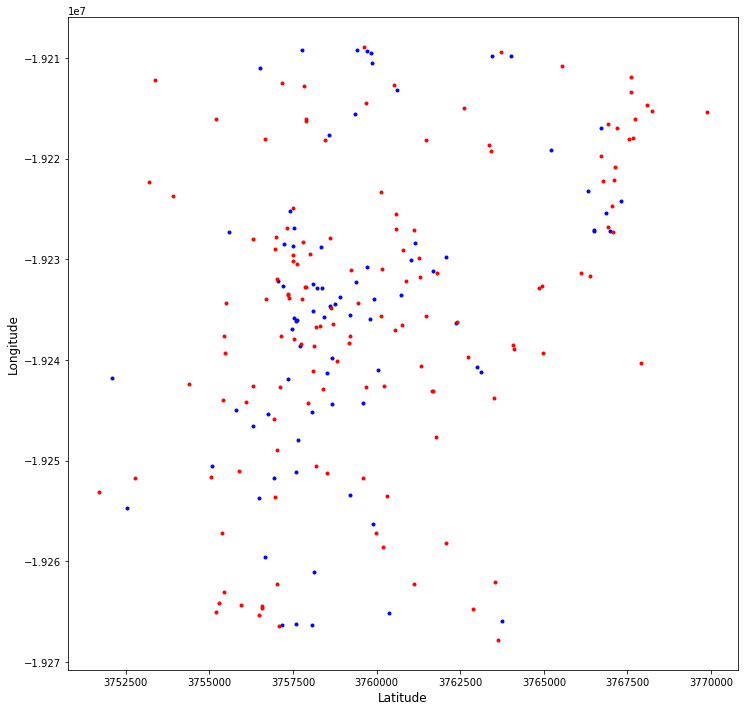

In [16]:
ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^']);
plt.figure(figsize=(12,12))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(id_n):
    cluster=np.where(id_label==i)[0]
    plt.plot(X.x_exit[cluster].values,X.y_exit[cluster].values,ptsymb[i])
plt.show()

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
dbscan = DBSCAN(eps=10000.0, min_samples = 10)
clusters = dbscan.fit_predict(X_scaled)

In [ ]:
# plot the cluster assignments
plt.scatter(X['x_exit'], X['y_exit'], c=clusters, cmap="plasma", s =0.01)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")
# plt.colorbar(clusters)